In [1472]:
import numpy as np
import MITgcmutils as mit
import matplotlib.tri as tri
import matplotlib.pyplot as plt
from matplotlib import animation

from scipy.spatial import cKDTree
from numba import njit
import MITgcmutils as mit
import cmocean 
# from matplotlib.colors import Normalize # Normalizeをimport
from matplotlib.colors import TwoSlopeNorm
from geopy.distance import great_circle
import cartopy.crs as ccrs
import os
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter

In [1473]:
@njit(cache=True)
def lonlat_to_xyz(lon, lat):
    """経度・緯度を3次元座標に変換"""
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)  # 度からラジアンに変換
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# @njit(cache=True)
def calculate_top_l_indices_and_norms_ckdtree(XCYC1, XCYC2, l):
    """
    XCYC2 の各点に対して、XCYC1 からノルムが小さい順に l 点のインデックスとノルムを計算（cKDTree を使用）。
    """
    # XCYC1 を3次元座標に変換して平坦化
    m, n = XCYC1.shape[:2]
    flattened_XCYC1 = XCYC1.reshape(-1, 2)
    points_xyz = np.array([lonlat_to_xyz(lon, lat) for lon, lat in flattened_XCYC1])

    # cKDTree を構築
    tree = cKDTree(points_xyz)

    # 結果を格納する配列を初期化
    top_l_indices = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l, 2), dtype=int)
    top_l_norms = np.zeros((XCYC2.shape[0], XCYC2.shape[1], l))  # ノルムを格納

    # 各点を探索
    for i in range(XCYC2.shape[0]):
        for j in range(XCYC2.shape[1]):
            lon_query, lat_query = XCYC2[i, j, :]  # 経度、緯度を取得
            x_query, y_query, z_query = lonlat_to_xyz(lon_query, lat_query)

            # 最近傍探索
            distances, indices = tree.query([x_query, y_query, z_query], k=l)

            # インデックスを 2D の形状に変換
            if l == 1:  # l=1 の場合、スカラーが返るので処理を分岐
                indices = [indices]  # リスト化
                distances = [distances]  # リスト化

            unraveled_indices = np.unravel_index(indices, (m, n))

            for k in range(l):
                # インデックスを格納
                top_l_indices[i, j, k, :] = [unraveled_indices[0][k], unraveled_indices[1][k]]

            # ノルムを計算（geopy を使用）
            for k in range(l):
                lon1, lat1 = XCYC1[top_l_indices[i, j, k, 0], top_l_indices[i, j, k, 1]]
                lon2, lat2 = XCYC2[i, j, 0], XCYC2[i, j, 1]

                top_l_norms[i, j, k] = great_circle((lat1, lon1), (lat2, lon2)).kilometers

    return top_l_indices, top_l_norms


@njit(cache=True)
def regrid_data(XCYC1, XCYC2, top_l_indices, top_l_norms, data, p=2.):
    """
    XCYC2 の各点に対応する data の値を IDW（逆距離加重法）で内挿。

    Args:
        XCYC1 (ndarray): 元の座標データ (形状: [m, n, 2])
        XCYC2 (ndarray): 対応する座標データ (形状: [p, q, 2])
        top_l_indices (ndarray): 最近傍 l 点のインデックス (形状: [p, q, l, 2])
        top_l_norms (ndarray): 最近傍 l 点のノルム (形状: [p, q, l])
        data (ndarray): 元データ (例: SSS) (形状: [m, n])
        p (float): 重み計算のパラメータ（デフォルトは 1.）

    Returns:
        regridded_data (ndarray): 変換後の座標 XCYC2 上に内挿されたデータ (形状: [p, q])
    """
    # 結果を格納する配列を初期化
    regridded_data = np.empty((XCYC2.shape[0], XCYC2.shape[1]))

    l = top_l_indices.shape[2]  # 最近傍点の数
    
    # データ内挿処理
    for i in range(XCYC2.shape[0]):  # XCYC2 の 1 軸目
        for j in range(XCYC2.shape[1]):  # XCYC2 の 2 軸目
            
            # 条件: 最近傍のノルムが閾値未満の場合、その値を直接代入
            # if top_l_norms[i, j, 0] < 1.e-10: #when unit is deg, worked well(to some extent).
            if top_l_norms[i, j, 0] < 1.e-4: #when unit is kilomerter, worked well.


                idx_x, idx_y = top_l_indices[i, j, 0]
                regridded_data[i, j] = data[idx_x, idx_y]
                continue
            
            # 各点の重み付けと加算
            weighted_sum = 0.0
            weight_total = 0.0
            for k in range(l):
                weight = top_l_norms[i, j, k] ** -p
                idx_x, idx_y = top_l_indices[i, j, k]
                weighted_sum += data[idx_x, idx_y] * weight
                weight_total += weight
            
            # 正規化（重みの合計で割る）
            regridded_data[i, j] = weighted_sum / (weight_total + 1.e-15) 


    return regridded_data


In [1474]:
fileloc_rank0='/home/tsuribeh/MITgcm/cases_tsuribeh_master/CNTL_test/rank_0/'
fileloc_rank1='/home/tsuribeh/MITgcm/cases_tsuribeh_master/CNTL_test/rank_1/'
fileloc_rank2='/home/tsuribeh/MITgcm/cases_tsuribeh_master/CNTL_test/rank_2/'

# fileloc_rank0='/home/tsuribeh/MITgcm/cases_tsuribeh_master/PRST_test/rank_0_10yr/'
# fileloc_rank1='/home/tsuribeh/MITgcm/cases_tsuribeh_master/PRST_test/rank_1_10yr/'
# fileloc_rank2='/home/tsuribeh/MITgcm/cases_tsuribeh_master/PRST_test/rank_2_10yr/'

# fileloc_rank0='/home/tsuribeh/MITgcm/cases_tsuribeh_master/PRSTwithRunoff_test/rank_0/'
# fileloc_rank1='/home/tsuribeh/MITgcm/cases_tsuribeh_master/PRSTwithRunoff_test/rank_1/'
# fileloc_rank2='/home/tsuribeh/MITgcm/cases_tsuribeh_master/PRSTwithRunoff_test/rank_2/'

ADAY = 60.*60.*24. #[s]
AMONTH = ADAY*30.
AYEAR = AMONTH*12.

MTU_ocn = 3600 #[s]
MTU_atm = 450 #[s]
# MTU_atm = 300 #[s]


In [1475]:
XC = mit.rdmds(fileloc_rank1+'XC')
YC = mit.rdmds(fileloc_rank1+'YC')
XCYC = np.stack([XC,YC],axis=2)

lon_ = np.linspace(-180,180,361)
lat_ = np.linspace(-90,90,181)
lon, lat = np.meshgrid(lon_, lat_)

triang = tri.Triangulation(XC.flatten(), YC.flatten())

# dataTime= AMONTH*360
dataTime= AMONTH*120
# dataTime= AMONTH*24

iter_ocn = np.arange(0, dataTime/MTU_ocn+1, AMONTH/MTU_ocn)
iter_atm = np.arange(0, dataTime/MTU_atm+1, AMONTH/MTU_atm)

Temp_ocn = mit.rdmds(fileloc_rank1 + 'T',list(iter_ocn))
Temp_atm = mit.rdmds(fileloc_rank2 + 'T',list(iter_atm))


In [1476]:
DXC = mit.rdmds(fileloc_rank1+'DXC')
DYC = mit.rdmds(fileloc_rank1+'DYC')
DRF = mit.rdmds(fileloc_rank1+'DRF')
hFacC = mit.rdmds(fileloc_rank1+'hFacC')
DVC = DXC*DYC*DRF*hFacC


In [1477]:
# Eta_ocn = mit.rdmds(fileloc_rank1 + 'Eta',list(iter_ocn)) #iter_ocn 時間方向の長さを持ったnumpy配列

# interpolator_Eta = tri.LinearTriInterpolator(triang, Eta_ocn[0].flatten())
# Eta_regrid = interpolator_Eta(lon, lat)

# fig = plt.figure()
# ax = plt.axes(projection=ccrs.PlateCarree())
# cf = ax.pcolormesh(lon,lat, Eta_regrid, vmin=-2., vmax=2., cmap=cmocean.cm.balance
#                    )

# # カラーバーを追加
# cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# cb.set_label("$\eta$ [m]")

# #グリッドと軸目盛を描く緯度経度を設定するための配列
# dlon,dlat=60,30
# xticks=np.arange(-180,180.1,dlon)
# yticks=np.arange(-90,90.1,dlat)

# #グリッド線を引く
# gl = ax.gridlines(crs=ccrs.PlateCarree()
#          , draw_labels=False
#          , linewidth=1, alpha=0.8)
# gl.xlocator = mticker.FixedLocator(xticks)    
# gl.ylocator = mticker.FixedLocator(yticks)
# #目盛を描く緯度経度の値を設定
# ax.set_xticks(xticks,crs=ccrs.PlateCarree())
# ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# # 目盛の表示形式を度数表記にする    
# latfmt=LatitudeFormatter()
# lonfmt=LongitudeFormatter(zero_direction_label=True)
# ax.xaxis.set_major_formatter(lonfmt)
# ax.yaxis.set_major_formatter(latfmt)
# #目盛のサイズを指定
# ax.axes.tick_params(labelsize=12)

In [1478]:
Eta_ocn = mit.rdmds(fileloc_rank1 + 'Eta',list(iter_ocn))


MovieWriter imagemagick unavailable; using Pillow instead.


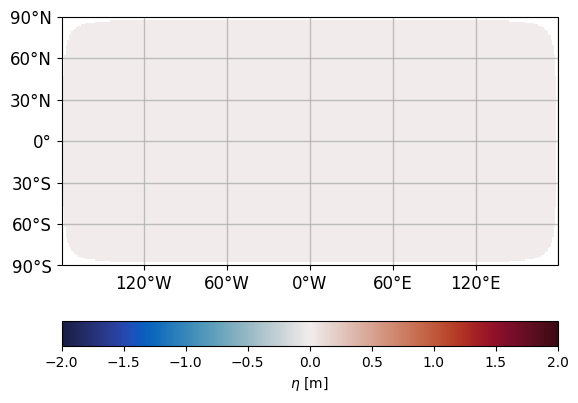

In [1479]:
from IPython.display import HTML
from matplotlib.animation import PillowWriter
# Eta_ocn: shape = (ntime, ny, nx)
ntime = Eta_ocn.shape[0]

# アニメーション用のFigureとAxes
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# グリッド線などの設定（固定）
dlon, dlat = 60, 30
xticks = np.arange(-180, 180.1, dlon)
yticks = np.arange(-90, 90.1, dlat)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)

ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
latfmt = LatitudeFormatter()
lonfmt = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
ax.tick_params(labelsize=12)

# 初期プロット
interpolator_Eta = tri.LinearTriInterpolator(triang, Eta_ocn[0].flatten())
Eta_regrid = interpolator_Eta(lon, lat)
cf = ax.pcolormesh(lon, lat, Eta_regrid, vmin=-2., vmax=2., cmap=cmocean.cm.balance)
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("$\eta$ [m]")

# アニメーション更新関数
def update(frame):
    global cf
    cf.remove()  # 前のpcolormeshを削除
    interpolator_Eta = tri.LinearTriInterpolator(triang, Eta_ocn[frame].flatten())
    Eta_regrid = interpolator_Eta(lon, lat)
    cf = ax.pcolormesh(lon, lat, Eta_regrid, vmin=-2., vmax=2., cmap=cmocean.cm.balance)
    return cf,

# アニメーション作成
ani = animation.FuncAnimation(fig, update, frames=range(ntime), interval=200, blit=False)

# # Jupyter内で表示
# HTML(ani.to_jshtml())
ani.save("Eta_animation.gif", writer='imagemagick')


In [1480]:

np.sum(DXC*DYC*Eta_ocn)/np.sum(DXC*DYC)


-22.450878634128188

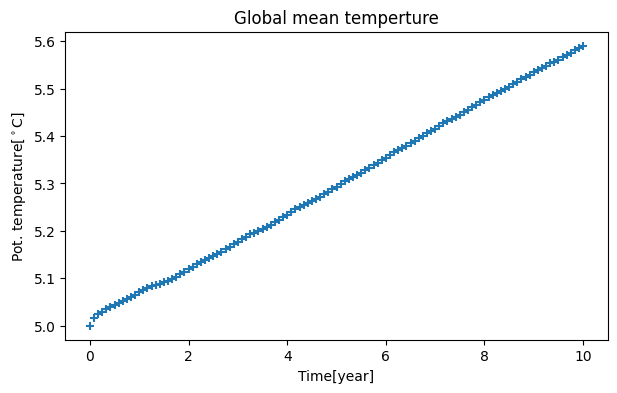

In [1481]:



TDVC = Temp_ocn*DVC

meanT = np.sum(TDVC, axis=(1,2,3))/DVC.sum()


fig=plt.figure(figsize=(7,4))
ax= fig.add_subplot(111)
ax.scatter(iter_ocn*MTU_ocn/AYEAR, meanT, marker='+')
ax.set_title('Global mean temperture')
ax.set_xlabel('Time[year]')
ax.set_ylabel('Pot. temperature[$^\circ$C]')

plt.show()




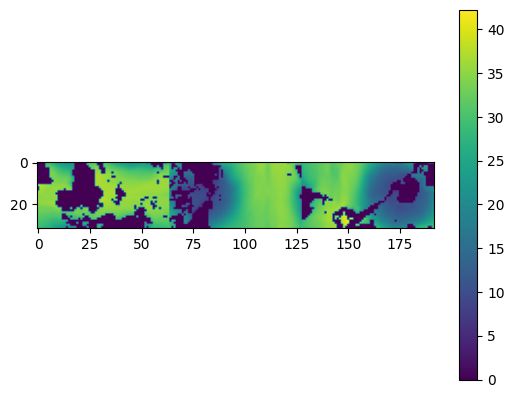

In [1482]:
plt.imshow(Temp_ocn[-1,0])
plt.colorbar()

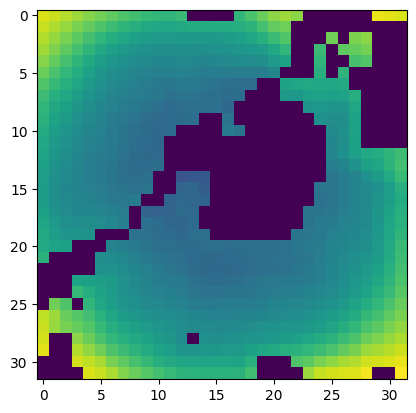

In [1483]:
plt.imshow(Temp_ocn[-1,0,:,-32:])


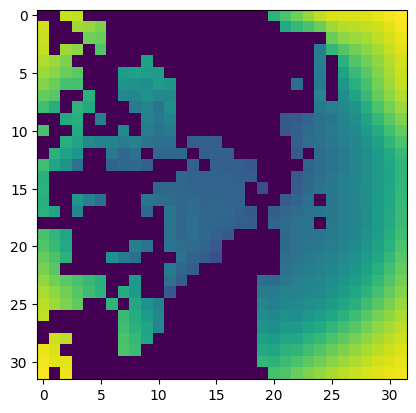

In [1484]:
plt.imshow(Temp_ocn[-1,0,:,64:96])


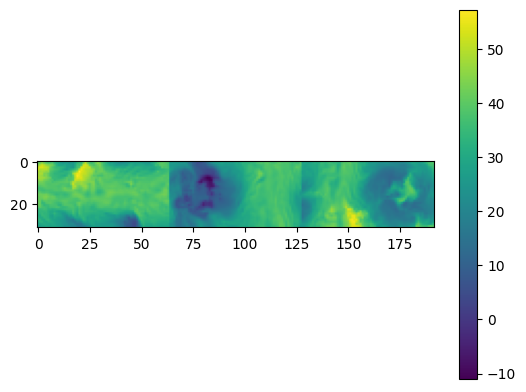

In [1485]:
plt.imshow(Temp_atm[-1,0]-273.15)
plt.colorbar()


In [1486]:
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
idx_ocn = 0
idx_atm =2


In [1487]:
interpolator_Temp1 = tri.LinearTriInterpolator(triang, Temp_ocn[-1,idx_ocn].flatten())
Temp1_regrid = interpolator_Temp1(lon, lat)

interpolator_Temp2 = tri.LinearTriInterpolator(triang, Temp_atm[-1,idx_atm].flatten())
Temp2_regrid = interpolator_Temp2(lon, lat)

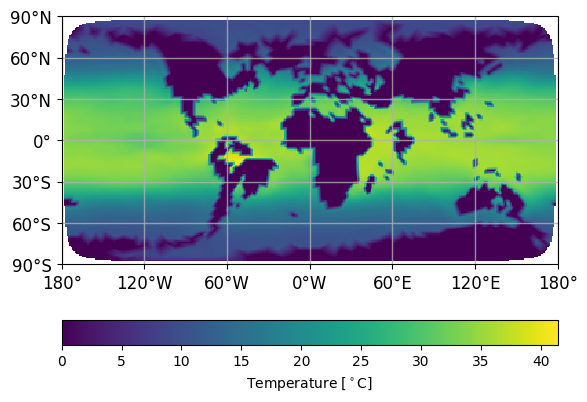

In [1488]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, Temp1_regrid#, vmax= 40., vmin =-2.
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("Temperature [${}^\circ\\mathrm{C}$]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

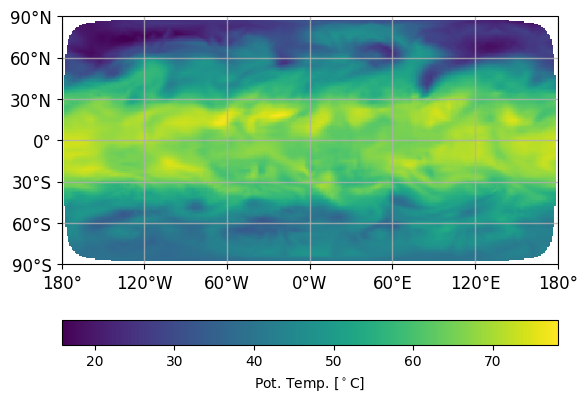

In [1489]:

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, Temp2_regrid- 273.5 #, vmax= 60.,vmin = -20.
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("Pot. Temp. [${}^\circ\\mathrm{C}$]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

In [1490]:
# FSOL = mit.rdmds(fileloc_rank2 + 'RadDiag',list(iter_atm)[1:])[1]
# interpolator_FSOL = tri.LinearTriInterpolator(triang, FSOL[-1].flatten())
FSOL = mit.rdmds(fileloc_rank2 + 'RadDiag',dataTime/MTU_atm)[1]
interpolator_FSOL = tri.LinearTriInterpolator(triang, FSOL.flatten())

FSOL1_regrid = interpolator_FSOL(lon, lat)

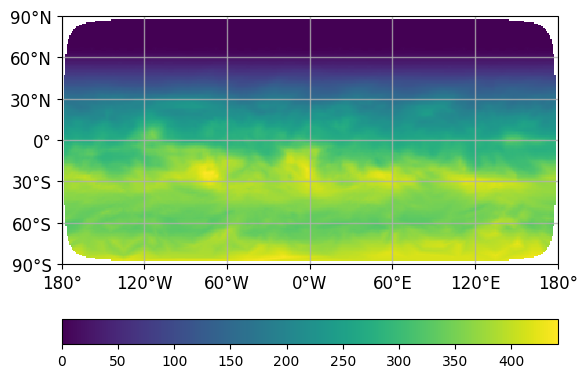

In [1491]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, FSOL1_regrid)

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# cb.set_label("Temp [K]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

大気、海洋、カップラーそれぞれシングルで10年回すのに2000分(35時間くらい)かかった。

In [1492]:
Socn = mit.rdmds(fileloc_rank1 + 'S',dataTime/MTU_ocn)
Satm = mit.rdmds(fileloc_rank2 + 'S',int(dataTime/MTU_atm))

In [1493]:
interpolator_Socn = tri.LinearTriInterpolator(triang, Socn[idx_ocn].flatten())
Socn_regrid = interpolator_Socn(lon, lat)

interpolator_Satm = tri.LinearTriInterpolator(triang, Satm[idx_atm].flatten())
Satm_regrid = interpolator_Satm(lon, lat)

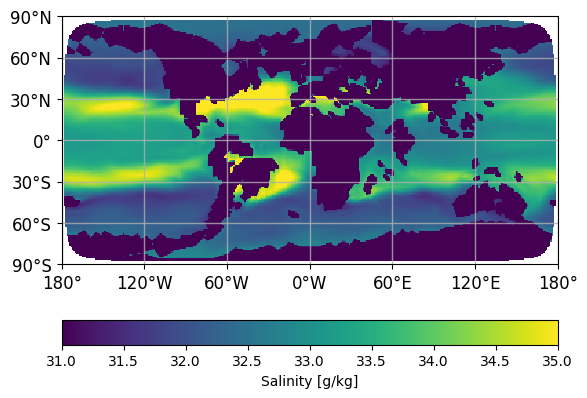

In [1494]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, Socn_regrid, vmin=31., vmax=35.
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("Salinity [g/kg]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

In [1495]:
Uocn = mit.rdmds(fileloc_rank1 + 'U',list(iter_ocn))
Uatm = mit.rdmds(fileloc_rank2 + 'U',list(iter_atm))

Uocn= Uocn[-12:].mean(axis=0)
Uatm= Uatm[-12:].mean(axis=0)


In [1496]:
lon_.shape

(361,)

In [1497]:
Uocn_regrid= np.empty((15,len(lat_),len(lon_)))
Uatm_regrid= np.empty((5,len(lat_),len(lon_)))
for k in range(15):
    interpolator_Uocn = tri.LinearTriInterpolator(triang, Uocn[k].flatten())
    Uocn_regrid[k] = np.array(interpolator_Uocn(lon, lat))
k=0
for k in range(5):
    interpolator_Uatm = tri.LinearTriInterpolator(triang, Uatm[k].flatten())
    Uatm_regrid[k] = interpolator_Uatm(lon, lat)





In [1498]:
np.unique(Uatm_regrid[0])

array([-15.46099514, -15.23474105, -15.18896777, ...,  15.69342531,
        15.73779459,          nan])

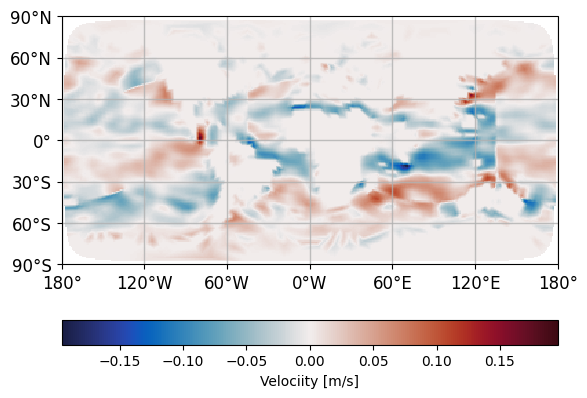

In [1499]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

Umin= min(np.nanmin(Uocn_regrid),-np.nanmax(Uocn_regrid))
cf = ax.pcolormesh(lon,lat, Uocn_regrid[0], cmap=cmocean.cm.balance, vmin = Umin, vmax=-Umin)
                   

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("Velociity [m/s]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

In [1500]:
Umin

-0.19558547751465793

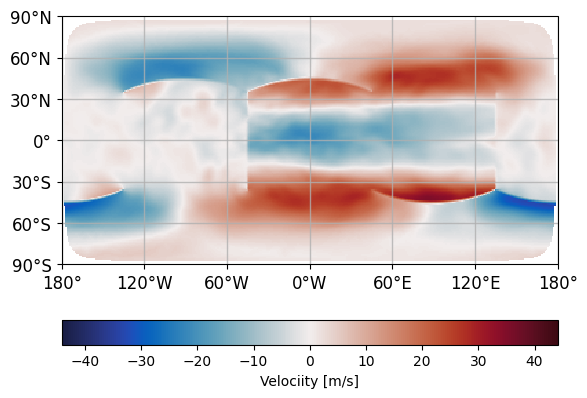

In [1501]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

Umin= min(np.nanmin(Uatm_regrid),-np.nanmax(Uatm_regrid))

cf = ax.pcolormesh(lon,lat, Uatm_regrid[4], cmap=cmocean.cm.balance, vmin = Umin, vmax=-Umin
                   )
                   

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("Velociity [m/s]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

In [1502]:
Uatm_regrid_znav = Uatm_regrid.copy()
for i in range(len(lon)):
    Uatm_regrid_znav[:,i,:] = np.nanmean(Uatm_regrid_znav[:,i])

/tmp/ipykernel_3778/3109301210.py:3: RuntimeWarning: Mean of empty slice
  Uatm_regrid_znav[:,i,:] = np.nanmean(Uatm_regrid_znav[:,i])


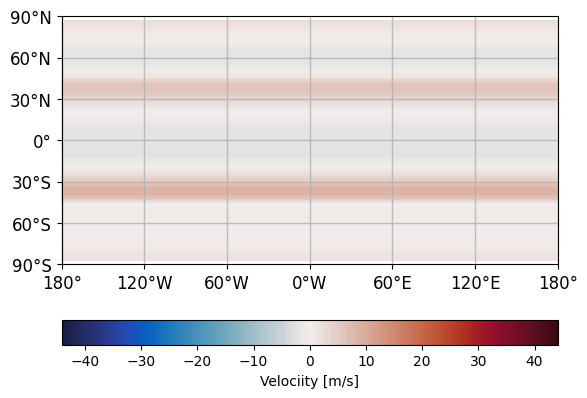

In [1503]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
Umin= min(np.nanmin(Uatm_regrid),-np.nanmax(Uatm_regrid))
cf = ax.pcolormesh(lon,lat, Uatm_regrid_znav[0], cmap=cmocean.cm.balance, vmin = Umin, vmax=-Umin)
                   

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("Velociity [m/s]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

/tmp/ipykernel_3778/1762447605.py:2: RuntimeWarning: Mean of empty slice
  Uatm_regrid_vrav = np.nanmean(Uatm_regrid, axis=2)  # shape = (5, lat)


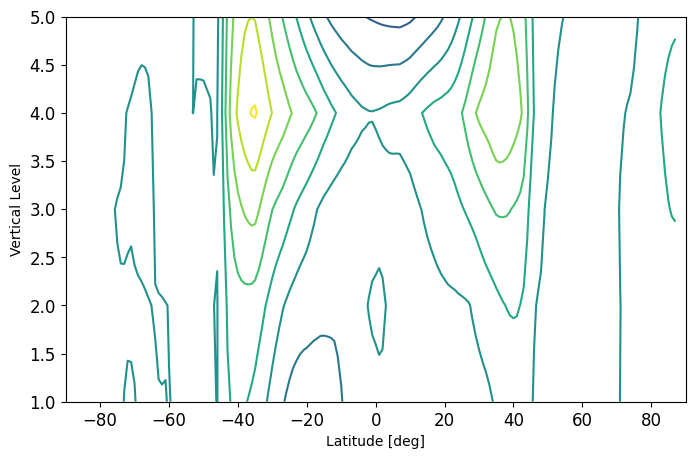

In [1513]:
# 鉛直平均した速度（例: Z×緯度）を描くなら、投影なしのプロットに
Uatm_regrid_vrav = np.nanmean(Uatm_regrid, axis=2)  # shape = (5, lat)
Z = np.arange(1, 6)  # shape = (5,)

# meshgrid を作る
lat2d,Z2d = np.meshgrid(lat_, Z)

# プロット
fig, ax = plt.subplots(figsize=(8, 5))
Umin = min(np.nanmin(Uatm_regrid_vrav), -np.nanmax(Uatm_regrid_vrav))
# cf = ax.pcolormesh(lat2d, Z2d,Uatm_regrid_vrav, cmap=cmocean.cm.balance, vmin=Umin, vmax=-Umin)
# cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# cb.set_label("Velocity [m/s]")

cf = ax.contour(lat2d, Z2d,Uatm_regrid_vrav, vmin=Umin, vmax=-Umin)




ax.set_ylabel("Vertical Level")
ax.set_xlabel("Latitude [deg]")
ax.tick_params(labelsize=12)


In [ ]:
# Uocn_regrid_znav = Uocn_regrid.copy()
# for i in range(len(lon)):
#     Uatm_regrid_znav[i,:] = np.mean(Uocn_regrid_znav[i])

IndexError: index 5 is out of bounds for axis 0 with size 5

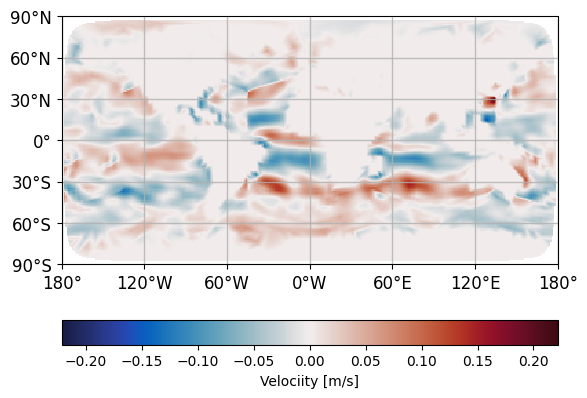

In [ ]:
fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
Umin= min(Uocn_regrid.min(),-Uocn_regrid.max())
cf = ax.pcolormesh(lon,lat, Uocn_regrid_znav, cmap=cmocean.cm.balance, vmin = Umin, vmax=-Umin)
                   

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("Velociity [m/s]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)